In [1]:
from PIL import Image
import torch
import torch.nn.functional as F
from torch.cuda import amp
import numpy as np
from torch.utils.mobile_optimizer import optimize_for_mobile

In [2]:
from remove_bg_utils import load_checkpoint_mgpu
from remove_bg_utils import U2NET

In [3]:
rbg_720 = U2NET(in_ch=3, out_ch=1)
rbg_720 = load_checkpoint_mgpu(rbg_720, "outer_100k.pth")

----checkpoints loaded from path: outer_100k.pth----


In [4]:
data = torch.randn(1, 3, 720, 720)
im = Image.open("ImageSegmentation/app/src/main/assets/car.jpg")
imarr = np.array(im)
data = torch.from_numpy(imarr[None])
data = data.permute(0,3,1,2).to(torch.float)

In [5]:
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    @torch.inference_mode()
    def forward(self, data):
        data = data.div(127.5).sub_(1.)
        x = torch.sigmoid_(self.model(data)[0])
        return x.mul_(255.)

In [6]:
wrp_model = WrappedModel(rbg_720).eval()

In [7]:
traced_script_module = torch.jit.trace(wrp_model, data)

/usr/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/lib/python3.10/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [8]:
torchscript_model_optimized = optimize_for_mobile(traced_script_module)

In [12]:
torchscript_model_optimized._save_for_lite_interpreter("ImageSegmentation/app/src/main/assets/u2net_exp.ptl")

In [10]:
o = torchscript_model_optimized(data)

/usr/lib/python3.10/site-packages/torch/nn/modules/module.py:1110: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /build/python-pytorch/src/pytorch-1.11.0-cuda/c10/core/TensorImpl.h:1460.)
  return forward_call(*input, **kwargs)


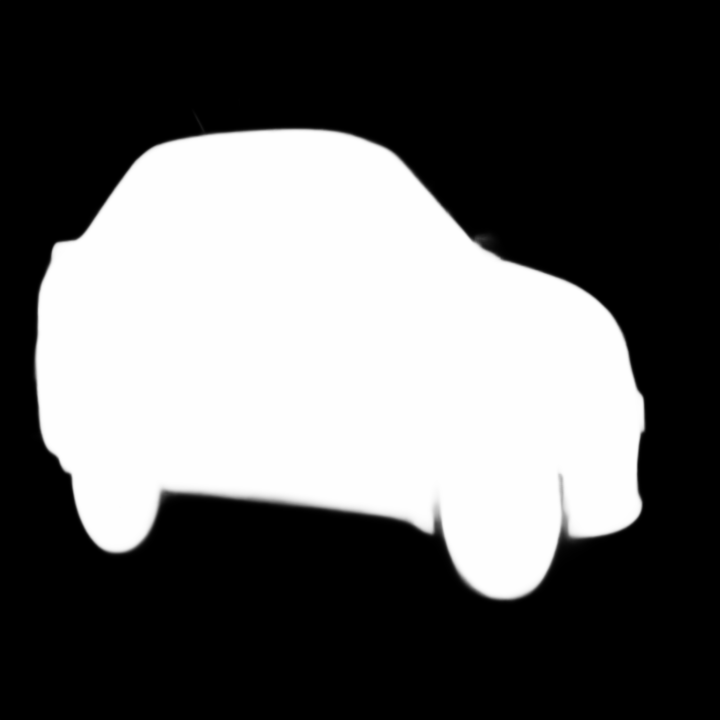

In [11]:
Image.fromarray(o.to(torch.uint8).cpu().numpy().squeeze())